# Feedforward Neural Network ON Fashion-MINIST

In [1]:
import utils.mnist_reader as mnist_reader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

seed = 0
np.random.seed(seed)

import warnings
from sklearn.exceptions import ConvergenceWarning

# Disable ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Load Fashion-MNIST dataset

In [2]:
X, y = mnist_reader.load_mnist('data/fashion', kind='train')

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=seed, shuffle=True) # Train Test Split used for training purposes

X_te, y_te = mnist_reader.load_mnist('data/fashion', kind='t10k') # The actual evaluation dataset

In [3]:
print('Training Set')
print(X_tr.shape) # 45000 rows, each row has 784 columns can be arranged in 28 * 28
print(y_tr.shape) # 45000 classifications

print('\nValuation Set')
print(X_val.shape) # 15000 rows, each row has 784 columns can be arranged in 28 * 28
print(y_val.shape) # 15000 classifications

print('\nTest Set')
print(X_te.shape) # 10000 rows, each row has 784 columns can be arranged in 28 * 28
print(y_te.shape) # 10000 classifications

Training Set
(45000, 784)
(45000,)

Valuation Set
(15000, 784)
(15000,)

Test Set
(10000, 784)
(10000,)


Normalize the dataset

In [4]:
# Normalization
scaler = StandardScaler()
scaler.fit(X)

X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)

## Tune Hyperparameters

Find the best parameters with `GridSearchCV`

In [5]:
# Define the parameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (50,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.01]
}

training_amount = 15000 # valid amounts are between 0 and 45000

# Create the MLP classifier
mlp = MLPClassifier(random_state=seed)

# Perform grid search to find the best parameters
grid_search = GridSearchCV(mlp, param_grid, cv=5)
grid_search.fit(X_tr[:training_amount], y_tr[:training_amount])

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=0),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.01],
                         'hidden_layer_sizes': [(50,), (50, 50)],
                         'solver': ['sgd', 'adam']})

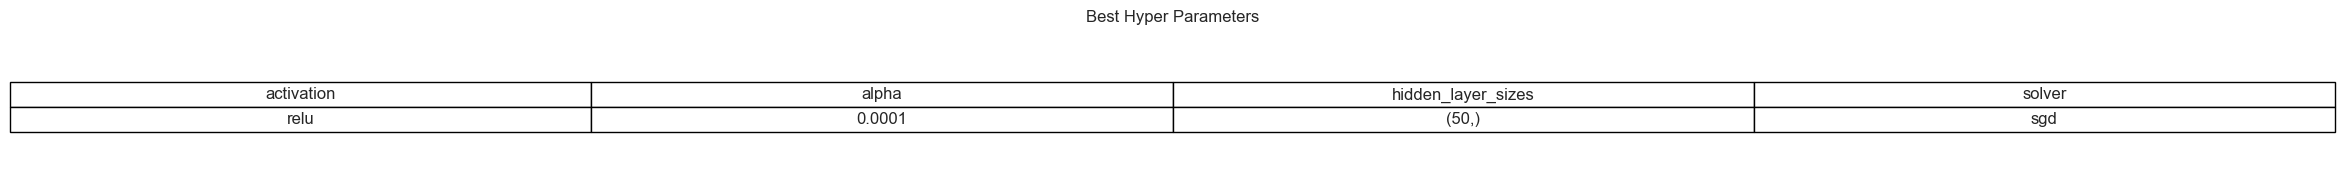

Best Accuracy Score: 0.8653333333333334
    mean_fit_time  std_fit_time  mean_score_time  std_score_time   
0       26.550298      3.863323         0.010450        0.003658  \
1       16.757498      1.373298         0.010148        0.001718   
2       28.196253      0.504304         0.011626        0.003978   
3       13.860821      3.483654         0.006857        0.000786   
4       23.921548      0.946361         0.007792        0.001911   
5       13.830159      2.067210         0.008169        0.001059   
6       28.383120      0.946572         0.009195        0.002010   
7       14.506980      2.151459         0.009041        0.001787   
8       23.080354      0.198352         0.008219        0.001015   
9       15.973748      0.297465         0.008985        0.002091   
10      29.151076      0.997386         0.011757        0.001285   
11      11.983566      0.147490         0.009708        0.001574   
12      23.406773      0.240733         0.007012        0.000548   
13      

In [8]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create the table to display the results
fig, ax = plt.subplots(figsize=(20, 2))
ax.axis('off')

table_data = [str(best_params), str(best_score)]

parameter_names = sorted(list(best_params.keys()))
parameter_values = [best_params[key] for key in parameter_names]

table = ax.table(cellText=[parameter_values], colLabels=parameter_names, cellLoc='center', loc='center')

# Set the table style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title('Best Hyper Parameters')
plt.show()

print(f'Best Accuracy Score: {best_score}')

df = pd.DataFrame(grid_search.cv_results_)
print(df)

## Tuning max_depth

In [5]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
tr_errs = []
val_errs = []
te_errs = []

training_amount = 15000

for lr in learning_rates:
    mlp = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(50,), solver='sgd', learning_rate_init=lr, random_state=seed)

    mlp.fit(X_tr[:training_amount], y_tr[:training_amount])

    mlp_train_pred = mlp.predict(X_tr[:training_amount])
    mlp_val_pred = mlp.predict(X_val)

    mlp_train_error = 1 - accuracy_score(y_tr[:training_amount], mlp_train_pred)
    mlp_val_error = 1 - accuracy_score(y_val, mlp_val_pred)

    tr_errs.append(mlp_train_error)
    val_errs.append(mlp_val_error)

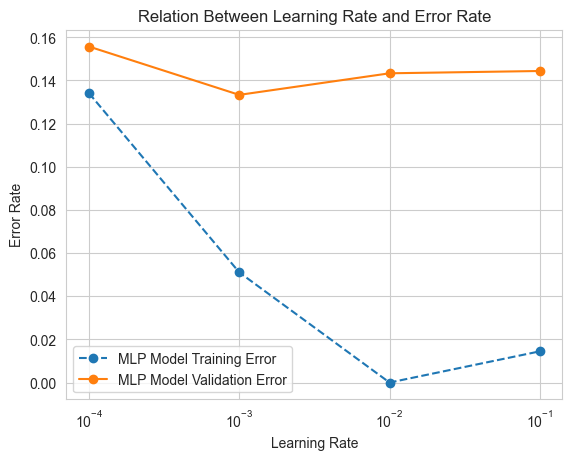

In [6]:
plt.figure()
plt.plot(learning_rates, tr_errs, 'o--', label='MLP Model Training Error')
plt.plot(learning_rates, val_errs, 'o-', label='MLP Model Validation Error')

plt.xlabel('Learning Rate')
plt.ylabel('Error Rate')
plt.xscale('log')
plt.title('Relation Between Learning Rate and Error Rate')

plt.legend()
plt.show()

Analysis: Based on the graph, choosing learning rate = 0.001 is the most appropriate because the model is not overfitting or underfitting.

Train a `MLPClassifier` with the best parameters found

In [15]:
# Train the MLP classifier with the best parameters
mlp_best = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(50,), solver='sgd', learning_rate_init=0.001, random_state=seed)
mlp_best.fit(X_tr, y_tr)

MLPClassifier(hidden_layer_sizes=(50,), random_state=0, solver='sgd')

## Evaluate the classifier

Calculate accuracy scores

In [16]:
y_tr_pred = mlp_best.predict(X_tr)
y_val_pred = mlp_best.predict(X_val)
y_test_pred = mlp_best.predict(X_te)

acc_tr = accuracy_score(y_tr, y_tr_pred)
acc_val = accuracy_score(y_val, y_val_pred)
acc_te = accuracy_score(y_te, y_test_pred)

print(f"The MLP Classifier Has Training Accuracy: {acc_tr}")
print(f"The MLP Classifier Has Validation Accuracy: {acc_val}")
print(f"The MLP Classifier Has Testing Accuracy: {acc_te}")

The MLP Classifier Has Training Accuracy: 0.9470444444444445
The MLP Classifier Has Validation Accuracy: 0.8828
The MLP Classifier Has Testing Accuracy: 0.8758


Create a confusion matrix

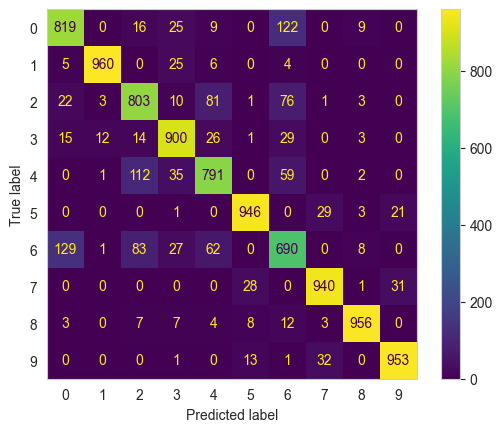

In [17]:
cm = confusion_matrix(y_te, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.show()

Create a classification report

<AxesSubplot: >

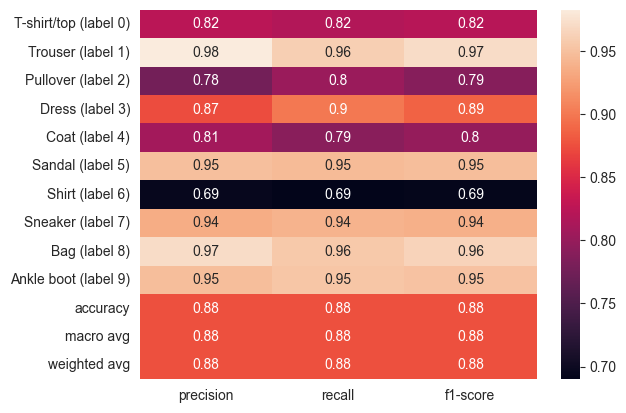

In [18]:
label2desc = {0: 'T-shirt/top (label 0)',
              1: 'Trouser (label 1)',
              2: 'Pullover (label 2)',
              3: 'Dress (label 3)',
              4: 'Coat (label 4)',
              5: 'Sandal (label 5)',
              6: 'Shirt (label 6)',
              7: 'Sneaker (label 7)',
              8: 'Bag (label 8)',
              9: 'Ankle boot (label 9)'}

report = classification_report(y_te, y_test_pred, target_names = label2desc.values(), output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

## Learning Curve

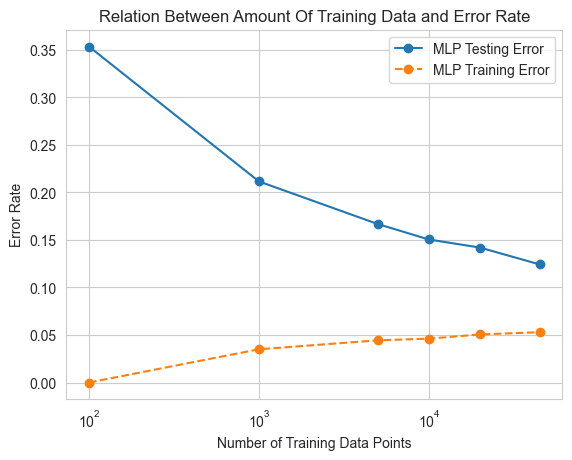

In [19]:
mlp_train_errors = []
mlp_test_errors = []

n_tr = [100, 1000, 5000, 10000, 20000, 45000]

for n in n_tr:

    # Get a sub portion of feature vectors
    sub_X_tr = X_tr[:n]
    sub_y_tr = y_tr[:n]

    # MLPClassifier
    mlp = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(50,), solver='sgd', learning_rate_init=0.001, random_state=seed)

    mlp.fit(sub_X_tr, sub_y_tr)

    mlp_train_pred = mlp.predict(X_tr[:n])
    mlp_test_pred = mlp.predict(X_te)

    mlp_train_error = 1 - accuracy_score(y_tr[:n], mlp_train_pred[:n])
    mlp_test_error = 1 - accuracy_score(y_te, mlp_test_pred)

    mlp_train_errors.append(mlp_train_error)
    mlp_test_errors.append(mlp_test_error)

plt.figure()
plt.plot(n_tr, mlp_test_errors, 'o-', label='MLP Testing Error')
plt.plot(n_tr, mlp_train_errors, 'o--', label='MLP Training Error')

plt.xlabel('Number of Training Data Points')
plt.ylabel('Error Rate')
plt.xscale('log')
plt.title('Relation Between Amount Of Training Data and Error Rate')

plt.legend()
plt.show()